In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
from torchvision import models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import time
from sklearn.metrics import f1_score
import timm


In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/xception/pytorch/xception/1/best_model.pth
/kaggle/input/jutepest/sample_submission.csv
/kaggle/input/jutepest/train.csv
/kaggle/input/jutepest/test.csv
/kaggle/input/jutepest/train_images/data_2198.jpg
/kaggle/input/jutepest/train_images/data_4627.jpg
/kaggle/input/jutepest/train_images/data_4335.jpg
/kaggle/input/jutepest/train_images/data_3267.jpg
/kaggle/input/jutepest/train_images/data_6807.jpg
/kaggle/input/jutepest/train_images/data_5147.jpg
/kaggle/input/jutepest/train_images/data_4768.jpg
/kaggle/input/jutepest/train_images/data_3090.jpg
/kaggle/input/jutepest/train_images/data_2961.jpg
/kaggle/input/jutepest/train_images/data_4147.jpg
/kaggle/input/jutepest/train_images/data_548.jpg
/kaggle/input/jutepest/train_images/data_2240.jpg
/kaggle/input/jutepest/train_images/data_1699.jpg
/kaggle/input/jutepest/train_images/data_2939.jpg
/kaggle/input/jutepest/train_images/data_4276.jpg
/kaggle/input/jutepest/train_images/data_2919.jpg
/kaggle/input/jutepest/train_image

In [3]:
# Load and preview the dataset
train = pd.read_csv('/kaggle/input/jutepest/train.csv')
train.head()

,filename,class
0,data_813.jpg,Jute Stem Weevil
1,data_6274.jpg,Mealybug
2,data_2317.jpg,Black Hairy
3,data_2124.jpg,Termite
4,data_5974.jpg,Jute Aphid


In [4]:
# Encode class labels to integers
label_encoder = LabelEncoder()
train['class'] = label_encoder.fit_transform(train['class'])

In [5]:
# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
])


In [6]:
# Define custom dataset class
class JutePestDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.dataframe.iloc[idx, 1]
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [7]:
# Create dataset and split into training and validation sets
train_dir = '/kaggle/input/jutepest/train_images/'
dataset = JutePestDataset(train, train_dir, transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

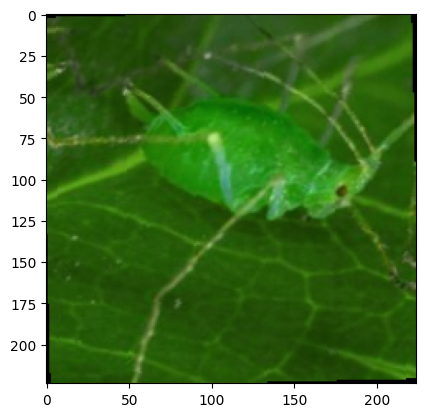

In [8]:
# Display a sample image
plt.imshow(torch.permute(dataset[4][0], (1, 2, 0)))
plt.show()

In [9]:
# Create DataLoader instances
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### XCeption


In [10]:
# Define a custom model using Xception from timm
class CustomXception(nn.Module):
    def __init__(self, num_classes):
        super(CustomXception, self).__init__()
        self.model = timm.create_model('xception', pretrained=False, num_classes=num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.model(x)
        x = self.dropout(x)
        return x

In [11]:
# Initialize the model, loss function, optimizer, and learning rate scheduler
model = CustomXception(num_classes=17)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # L2 regularization
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.75)

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [12]:
# Print model summary
from torchinfo import summary
summary(model, (32, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
CustomXception                                [32, 17]                  --
├─Xception: 1-1                               [32, 17]                  --
│    └─Conv2d: 2-1                            [32, 32, 111, 111]        864
│    └─BatchNorm2d: 2-2                       [32, 32, 111, 111]        64
│    └─ReLU: 2-3                              [32, 32, 111, 111]        --
│    └─Conv2d: 2-4                            [32, 64, 109, 109]        18,432
│    └─BatchNorm2d: 2-5                       [32, 64, 109, 109]        128
│    └─ReLU: 2-6                              [32, 64, 109, 109]        --
│    └─Block: 2-7                             [32, 128, 55, 55]         --
│    │    └─Sequential: 3-1                   [32, 128, 55, 55]         26,816
│    │    └─Conv2d: 3-2                       [32, 128, 55, 55]         8,192
│    │    └─BatchNorm2d: 3-3                  [32, 128, 55, 55]         256
│    └

In [13]:
# Determine the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()
model.to(device)

CustomXception(
  (model): Xception(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU(inplace=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rep): Sequential(
        (0): SeparableConv2d(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inpl

In [14]:
# Fungsi untuk menghitung akurasi
def calc_accuracy(true, pred):
    pred = F.softmax(pred, dim=1)
    acc = (true == pred.argmax(dim=1)).float().mean().item()
    return round(acc * 100, 2)

In [15]:
# Fungsi untuk menghitung F1 Score
def calc_f1_score(true, pred):
    pred = F.softmax(pred, dim=1).argmax(dim=1)
    true = true.cpu().numpy()
    pred = pred.cpu().numpy()
    return f1_score(true, pred, average='weighted')

## Melanjutkan Epoch Sebelumnya


In [16]:
checkpoint_path = ''

# Check if checkpoint exists
if os.path.exists(checkpoint_path) and checkpoint_path:
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_val_loss = checkpoint['best_val_loss']
    patience_counter = checkpoint['patience_counter']
    train_loss = checkpoint['train_loss']
    train_accuracy = checkpoint['train_accuracy']
    train_f1_score = checkpoint['train_f1_score']
    val_loss = checkpoint['val_loss']
    val_accuracy = checkpoint['val_accuracy']
    val_f1_score = checkpoint['val_f1_score']
    print(f"Checkpoint loaded, starting from epoch {start_epoch}")
else:
    # Initialize training and validation statistics
    start_epoch = 0
    best_val_loss = np.inf
    patience_counter = 0
    train_loss = []
    train_accuracy = []
    train_f1_score = []
    val_loss = []
    val_accuracy = []
    val_f1_score = []
    print("No checkpoint found, starting from scratch")

No checkpoint found, starting from scratch


## Training

In [17]:
# Initialize training and validation statistics
epochs = 100
patience = 6

In [18]:
# Training loop
for epoch in range(start_epoch, epochs):
    start_time = time.time()
    train_epoch_loss = []
    train_epoch_accuracy = []
    train_epoch_f1_score = []
    val_epoch_loss = []
    val_epoch_accuracy = []
    val_epoch_f1_score = []

    model.train()
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}", unit='batch') as pbar:
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            preds = model(images)
            acc = calc_accuracy(labels, preds)
            f1 = calc_f1_score(labels, preds)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()

            train_epoch_loss.append(loss.item())
            train_epoch_accuracy.append(acc)
            train_epoch_f1_score.append(f1)

            pbar.set_postfix({'Training Loss': np.mean(train_epoch_loss), 'Training Accuracy': np.mean(train_epoch_accuracy), 'Training F1 Score': np.mean(train_epoch_f1_score)})
            pbar.update(1)

    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            acc = calc_accuracy(labels, preds)
            f1 = calc_f1_score(labels, preds)
            loss = criterion(preds, labels)

            val_epoch_loss.append(loss.item())
            val_epoch_accuracy.append(acc)
            val_epoch_f1_score.append(f1)

    train_epoch_loss = np.mean(train_epoch_loss)
    train_epoch_accuracy = np.mean(train_epoch_accuracy)
    train_epoch_f1_score = np.mean(train_epoch_f1_score)
    val_epoch_loss = np.mean(val_epoch_loss)
    val_epoch_accuracy = np.mean(val_epoch_accuracy)
    val_epoch_f1_score = np.mean(val_epoch_f1_score)

    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    train_f1_score.append(train_epoch_f1_score)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    val_f1_score.append(val_epoch_f1_score)

    end_time = time.time()
    epoch_duration = end_time - start_time

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_epoch_accuracy:.2f}%, Training F1 Score: {train_epoch_f1_score:.2f}")
    print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.2f}%, Validation F1 Score: {val_epoch_f1_score:.2f}, Epoch Duration: {epoch_duration:.2f} seconds")

    # Save the model and optimizer state every 10 epochs
    if (epoch + 1) % 10 == 0 or (epoch + 1) == epochs:
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'patience_counter': patience_counter,
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'train_f1_score': train_f1_score,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
            'val_f1_score': val_f1_score
        }
        torch.save(checkpoint, f'checkpoint_epoch_{epoch + 1}.pth')
        print(f'Model saved at epoch {epoch + 1}')

    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        patience_counter = 0
        checkpoint_best = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'patience_counter': patience_counter,
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'train_f1_score': train_f1_score,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
            'val_f1_score': val_f1_score
        }
        torch.save(checkpoint_best, 'checkpoint_best.pth')
        torch.save(model.state_dict(), 'best_model.pth')
        print('Best model saved')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'patience_counter': patience_counter,
                'train_loss': train_loss,
                'train_accuracy': train_accuracy,
                'train_f1_score': train_f1_score,
                'val_loss': val_loss,
                'val_accuracy': val_accuracy,
                'val_f1_score': val_f1_score
            }
            torch.save(checkpoint, f'checkpoint_epoch_{epoch + 1}.pth')
            print(f'Model saved at epoch {epoch + 1} due to early stopping')
            break

    lr_scheduler.step()

Epoch 1/100: 100%|██████████| 154/154 [01:51<00:00,  1.39batch/s, Training Loss=2.58, Training Accuracy=19.2, Training F1 Score=0.182]


Epoch 1/100, Training Loss: 2.5800, Training Accuracy: 19.18%, Training F1 Score: 0.18
Validation Loss: 2.1807, Validation Accuracy: 32.81%, Validation F1 Score: 0.31, Epoch Duration: 130.02 seconds
Best model saved


Epoch 2/100: 100%|██████████| 154/154 [01:31<00:00,  1.69batch/s, Training Loss=2.33, Training Accuracy=26.2, Training F1 Score=0.264]


Epoch 2/100, Training Loss: 2.3340, Training Accuracy: 26.18%, Training F1 Score: 0.26
Validation Loss: 1.9089, Validation Accuracy: 46.19%, Validation F1 Score: 0.45, Epoch Duration: 105.47 seconds
Best model saved


Epoch 3/100: 100%|██████████| 154/154 [01:31<00:00,  1.69batch/s, Training Loss=2.18, Training Accuracy=30.4, Training F1 Score=0.314]


Epoch 3/100, Training Loss: 2.1784, Training Accuracy: 30.44%, Training F1 Score: 0.31
Validation Loss: 1.7600, Validation Accuracy: 49.58%, Validation F1 Score: 0.49, Epoch Duration: 105.40 seconds
Best model saved


Epoch 4/100: 100%|██████████| 154/154 [01:31<00:00,  1.69batch/s, Training Loss=2.04, Training Accuracy=34.2, Training F1 Score=0.353]


Epoch 4/100, Training Loss: 2.0436, Training Accuracy: 34.15%, Training F1 Score: 0.35
Validation Loss: 1.4205, Validation Accuracy: 61.93%, Validation F1 Score: 0.60, Epoch Duration: 105.88 seconds
Best model saved


Epoch 5/100: 100%|██████████| 154/154 [01:30<00:00,  1.70batch/s, Training Loss=1.91, Training Accuracy=37.6, Training F1 Score=0.392]


Epoch 5/100, Training Loss: 1.9058, Training Accuracy: 37.58%, Training F1 Score: 0.39
Validation Loss: 1.2754, Validation Accuracy: 65.21%, Validation F1 Score: 0.64, Epoch Duration: 104.98 seconds
Best model saved


Epoch 6/100: 100%|██████████| 154/154 [01:31<00:00,  1.69batch/s, Training Loss=1.81, Training Accuracy=39.8, Training F1 Score=0.42]


Epoch 6/100, Training Loss: 1.8074, Training Accuracy: 39.79%, Training F1 Score: 0.42
Validation Loss: 1.0379, Validation Accuracy: 73.73%, Validation F1 Score: 0.73, Epoch Duration: 105.81 seconds
Best model saved


Epoch 7/100: 100%|██████████| 154/154 [01:31<00:00,  1.69batch/s, Training Loss=1.69, Training Accuracy=42, Training F1 Score=0.447]


Epoch 7/100, Training Loss: 1.6870, Training Accuracy: 42.04%, Training F1 Score: 0.45
Validation Loss: 0.9232, Validation Accuracy: 76.90%, Validation F1 Score: 0.76, Epoch Duration: 105.25 seconds
Best model saved


Epoch 8/100: 100%|██████████| 154/154 [01:31<00:00,  1.69batch/s, Training Loss=1.61, Training Accuracy=44.3, Training F1 Score=0.466]


Epoch 8/100, Training Loss: 1.6124, Training Accuracy: 44.28%, Training F1 Score: 0.47
Validation Loss: 0.9005, Validation Accuracy: 79.79%, Validation F1 Score: 0.79, Epoch Duration: 105.83 seconds
Best model saved


Epoch 9/100: 100%|██████████| 154/154 [01:31<00:00,  1.69batch/s, Training Loss=1.53, Training Accuracy=45.8, Training F1 Score=0.485]


Epoch 9/100, Training Loss: 1.5313, Training Accuracy: 45.77%, Training F1 Score: 0.49
Validation Loss: 0.7797, Validation Accuracy: 78.90%, Validation F1 Score: 0.78, Epoch Duration: 105.48 seconds
Best model saved


Epoch 10/100: 100%|██████████| 154/154 [01:31<00:00,  1.69batch/s, Training Loss=1.52, Training Accuracy=46.2, Training F1 Score=0.49]


Epoch 10/100, Training Loss: 1.5242, Training Accuracy: 46.23%, Training F1 Score: 0.49
Validation Loss: 0.8063, Validation Accuracy: 78.00%, Validation F1 Score: 0.77, Epoch Duration: 105.89 seconds
Model saved at epoch 10


Epoch 11/100: 100%|██████████| 154/154 [01:31<00:00,  1.68batch/s, Training Loss=1.47, Training Accuracy=47.1, Training F1 Score=0.501]


Epoch 11/100, Training Loss: 1.4702, Training Accuracy: 47.06%, Training F1 Score: 0.50
Validation Loss: 0.6139, Validation Accuracy: 86.14%, Validation F1 Score: 0.86, Epoch Duration: 106.55 seconds
Best model saved


Epoch 12/100: 100%|██████████| 154/154 [01:32<00:00,  1.67batch/s, Training Loss=1.42, Training Accuracy=47.9, Training F1 Score=0.506]


Epoch 12/100, Training Loss: 1.4191, Training Accuracy: 47.91%, Training F1 Score: 0.51
Validation Loss: 0.5713, Validation Accuracy: 86.22%, Validation F1 Score: 0.86, Epoch Duration: 106.36 seconds
Best model saved


Epoch 13/100: 100%|██████████| 154/154 [01:31<00:00,  1.68batch/s, Training Loss=1.39, Training Accuracy=47.9, Training F1 Score=0.512]


Epoch 13/100, Training Loss: 1.3943, Training Accuracy: 47.93%, Training F1 Score: 0.51
Validation Loss: 0.5190, Validation Accuracy: 87.10%, Validation F1 Score: 0.87, Epoch Duration: 106.21 seconds
Best model saved


Epoch 14/100: 100%|██████████| 154/154 [01:31<00:00,  1.69batch/s, Training Loss=1.39, Training Accuracy=48, Training F1 Score=0.511]


Epoch 14/100, Training Loss: 1.3897, Training Accuracy: 48.03%, Training F1 Score: 0.51
Validation Loss: 0.5817, Validation Accuracy: 84.45%, Validation F1 Score: 0.84, Epoch Duration: 105.11 seconds


Epoch 15/100: 100%|██████████| 154/154 [01:31<00:00,  1.69batch/s, Training Loss=1.39, Training Accuracy=47.7, Training F1 Score=0.508]


Epoch 15/100, Training Loss: 1.3905, Training Accuracy: 47.74%, Training F1 Score: 0.51
Validation Loss: 0.4641, Validation Accuracy: 89.32%, Validation F1 Score: 0.89, Epoch Duration: 105.53 seconds
Best model saved


Epoch 16/100: 100%|██████████| 154/154 [01:31<00:00,  1.69batch/s, Training Loss=1.3, Training Accuracy=50.4, Training F1 Score=0.534]


Epoch 16/100, Training Loss: 1.2993, Training Accuracy: 50.43%, Training F1 Score: 0.53
Validation Loss: 0.4475, Validation Accuracy: 89.74%, Validation F1 Score: 0.89, Epoch Duration: 105.77 seconds
Best model saved


Epoch 17/100: 100%|██████████| 154/154 [01:30<00:00,  1.71batch/s, Training Loss=1.28, Training Accuracy=50.8, Training F1 Score=0.538]


Epoch 17/100, Training Loss: 1.2765, Training Accuracy: 50.78%, Training F1 Score: 0.54
Validation Loss: 0.4070, Validation Accuracy: 89.98%, Validation F1 Score: 0.89, Epoch Duration: 104.59 seconds
Best model saved


Epoch 18/100: 100%|██████████| 154/154 [01:31<00:00,  1.69batch/s, Training Loss=1.29, Training Accuracy=49.5, Training F1 Score=0.526]


Epoch 18/100, Training Loss: 1.2938, Training Accuracy: 49.47%, Training F1 Score: 0.53
Validation Loss: 0.4813, Validation Accuracy: 87.66%, Validation F1 Score: 0.87, Epoch Duration: 105.22 seconds


Epoch 19/100: 100%|██████████| 154/154 [01:30<00:00,  1.69batch/s, Training Loss=1.25, Training Accuracy=51.6, Training F1 Score=0.55]


Epoch 19/100, Training Loss: 1.2508, Training Accuracy: 51.63%, Training F1 Score: 0.55
Validation Loss: 0.4237, Validation Accuracy: 88.94%, Validation F1 Score: 0.88, Epoch Duration: 105.21 seconds


Epoch 20/100: 100%|██████████| 154/154 [01:30<00:00,  1.70batch/s, Training Loss=1.24, Training Accuracy=51.2, Training F1 Score=0.543]


Epoch 20/100, Training Loss: 1.2383, Training Accuracy: 51.24%, Training F1 Score: 0.54
Validation Loss: 0.3742, Validation Accuracy: 91.26%, Validation F1 Score: 0.91, Epoch Duration: 104.91 seconds
Model saved at epoch 20
Best model saved


Epoch 21/100: 100%|██████████| 154/154 [01:30<00:00,  1.70batch/s, Training Loss=1.25, Training Accuracy=50.7, Training F1 Score=0.538]


Epoch 21/100, Training Loss: 1.2472, Training Accuracy: 50.71%, Training F1 Score: 0.54
Validation Loss: 0.3323, Validation Accuracy: 91.48%, Validation F1 Score: 0.91, Epoch Duration: 105.43 seconds
Best model saved


Epoch 22/100: 100%|██████████| 154/154 [01:30<00:00,  1.69batch/s, Training Loss=1.18, Training Accuracy=53.1, Training F1 Score=0.566]


Epoch 22/100, Training Loss: 1.1753, Training Accuracy: 53.09%, Training F1 Score: 0.57
Validation Loss: 0.3299, Validation Accuracy: 91.51%, Validation F1 Score: 0.91, Epoch Duration: 105.09 seconds
Best model saved


Epoch 23/100: 100%|██████████| 154/154 [01:31<00:00,  1.69batch/s, Training Loss=1.2, Training Accuracy=52.5, Training F1 Score=0.557]


Epoch 23/100, Training Loss: 1.1987, Training Accuracy: 52.53%, Training F1 Score: 0.56
Validation Loss: 0.3361, Validation Accuracy: 91.27%, Validation F1 Score: 0.91, Epoch Duration: 105.21 seconds


Epoch 24/100: 100%|██████████| 154/154 [01:31<00:00,  1.68batch/s, Training Loss=1.18, Training Accuracy=52.9, Training F1 Score=0.561]


Epoch 24/100, Training Loss: 1.1843, Training Accuracy: 52.93%, Training F1 Score: 0.56
Validation Loss: 0.3346, Validation Accuracy: 90.87%, Validation F1 Score: 0.90, Epoch Duration: 105.75 seconds


Epoch 25/100: 100%|██████████| 154/154 [01:31<00:00,  1.68batch/s, Training Loss=1.22, Training Accuracy=51.6, Training F1 Score=0.551]


Epoch 25/100, Training Loss: 1.2163, Training Accuracy: 51.58%, Training F1 Score: 0.55
Validation Loss: 0.3343, Validation Accuracy: 90.70%, Validation F1 Score: 0.90, Epoch Duration: 106.13 seconds


Epoch 26/100: 100%|██████████| 154/154 [01:31<00:00,  1.68batch/s, Training Loss=1.21, Training Accuracy=51.5, Training F1 Score=0.549]


Epoch 26/100, Training Loss: 1.2081, Training Accuracy: 51.45%, Training F1 Score: 0.55
Validation Loss: 0.2938, Validation Accuracy: 92.79%, Validation F1 Score: 0.93, Epoch Duration: 106.70 seconds
Best model saved


Epoch 27/100: 100%|██████████| 154/154 [01:31<00:00,  1.67batch/s, Training Loss=1.17, Training Accuracy=53, Training F1 Score=0.56]


Epoch 27/100, Training Loss: 1.1695, Training Accuracy: 53.04%, Training F1 Score: 0.56
Validation Loss: 0.2799, Validation Accuracy: 92.95%, Validation F1 Score: 0.92, Epoch Duration: 106.24 seconds
Best model saved


Epoch 28/100: 100%|██████████| 154/154 [01:31<00:00,  1.68batch/s, Training Loss=1.15, Training Accuracy=54, Training F1 Score=0.573]


Epoch 28/100, Training Loss: 1.1487, Training Accuracy: 53.97%, Training F1 Score: 0.57
Validation Loss: 0.2810, Validation Accuracy: 93.19%, Validation F1 Score: 0.93, Epoch Duration: 106.00 seconds


Epoch 29/100: 100%|██████████| 154/154 [01:30<00:00,  1.69batch/s, Training Loss=1.17, Training Accuracy=52.9, Training F1 Score=0.564]


Epoch 29/100, Training Loss: 1.1685, Training Accuracy: 52.94%, Training F1 Score: 0.56
Validation Loss: 0.2914, Validation Accuracy: 92.95%, Validation F1 Score: 0.93, Epoch Duration: 105.23 seconds


Epoch 30/100: 100%|██████████| 154/154 [01:31<00:00,  1.69batch/s, Training Loss=1.16, Training Accuracy=52.8, Training F1 Score=0.557]


Epoch 30/100, Training Loss: 1.1634, Training Accuracy: 52.83%, Training F1 Score: 0.56
Validation Loss: 0.2741, Validation Accuracy: 92.63%, Validation F1 Score: 0.93, Epoch Duration: 105.62 seconds
Model saved at epoch 30
Best model saved


Epoch 31/100: 100%|██████████| 154/154 [01:31<00:00,  1.69batch/s, Training Loss=1.13, Training Accuracy=54.5, Training F1 Score=0.577]


Epoch 31/100, Training Loss: 1.1337, Training Accuracy: 54.51%, Training F1 Score: 0.58
Validation Loss: 0.2662, Validation Accuracy: 93.99%, Validation F1 Score: 0.94, Epoch Duration: 106.39 seconds
Best model saved


Epoch 32/100: 100%|██████████| 154/154 [01:31<00:00,  1.68batch/s, Training Loss=1.12, Training Accuracy=54.8, Training F1 Score=0.579]


Epoch 32/100, Training Loss: 1.1174, Training Accuracy: 54.80%, Training F1 Score: 0.58
Validation Loss: 0.2742, Validation Accuracy: 93.19%, Validation F1 Score: 0.93, Epoch Duration: 105.63 seconds


Epoch 33/100: 100%|██████████| 154/154 [01:32<00:00,  1.66batch/s, Training Loss=1.13, Training Accuracy=54, Training F1 Score=0.57]


Epoch 33/100, Training Loss: 1.1291, Training Accuracy: 54.00%, Training F1 Score: 0.57
Validation Loss: 0.2772, Validation Accuracy: 92.87%, Validation F1 Score: 0.92, Epoch Duration: 107.36 seconds


Epoch 34/100: 100%|██████████| 154/154 [01:32<00:00,  1.66batch/s, Training Loss=1.13, Training Accuracy=54.1, Training F1 Score=0.575]


Epoch 34/100, Training Loss: 1.1252, Training Accuracy: 54.14%, Training F1 Score: 0.58
Validation Loss: 0.2867, Validation Accuracy: 92.31%, Validation F1 Score: 0.92, Epoch Duration: 107.39 seconds


Epoch 35/100: 100%|██████████| 154/154 [01:31<00:00,  1.68batch/s, Training Loss=1.17, Training Accuracy=52, Training F1 Score=0.548]


Epoch 35/100, Training Loss: 1.1686, Training Accuracy: 52.04%, Training F1 Score: 0.55
Validation Loss: 0.2723, Validation Accuracy: 92.79%, Validation F1 Score: 0.92, Epoch Duration: 106.24 seconds


Epoch 36/100: 100%|██████████| 154/154 [01:32<00:00,  1.66batch/s, Training Loss=1.12, Training Accuracy=53.7, Training F1 Score=0.566]


Epoch 36/100, Training Loss: 1.1174, Training Accuracy: 53.67%, Training F1 Score: 0.57
Validation Loss: 0.2436, Validation Accuracy: 92.87%, Validation F1 Score: 0.92, Epoch Duration: 107.01 seconds
Best model saved


Epoch 37/100: 100%|██████████| 154/154 [01:32<00:00,  1.67batch/s, Training Loss=1.11, Training Accuracy=54.1, Training F1 Score=0.57]


Epoch 37/100, Training Loss: 1.1142, Training Accuracy: 54.13%, Training F1 Score: 0.57
Validation Loss: 0.2797, Validation Accuracy: 92.63%, Validation F1 Score: 0.92, Epoch Duration: 106.68 seconds


Epoch 38/100: 100%|██████████| 154/154 [01:31<00:00,  1.68batch/s, Training Loss=1.1, Training Accuracy=55.2, Training F1 Score=0.581]


Epoch 38/100, Training Loss: 1.1026, Training Accuracy: 55.17%, Training F1 Score: 0.58
Validation Loss: 0.2747, Validation Accuracy: 92.79%, Validation F1 Score: 0.92, Epoch Duration: 106.58 seconds


Epoch 39/100: 100%|██████████| 154/154 [01:32<00:00,  1.67batch/s, Training Loss=1.13, Training Accuracy=53.6, Training F1 Score=0.562]


Epoch 39/100, Training Loss: 1.1294, Training Accuracy: 53.55%, Training F1 Score: 0.56
Validation Loss: 0.2650, Validation Accuracy: 93.51%, Validation F1 Score: 0.93, Epoch Duration: 106.63 seconds


Epoch 40/100: 100%|██████████| 154/154 [01:31<00:00,  1.68batch/s, Training Loss=1.13, Training Accuracy=53.6, Training F1 Score=0.567]


Epoch 40/100, Training Loss: 1.1293, Training Accuracy: 53.60%, Training F1 Score: 0.57
Validation Loss: 0.2307, Validation Accuracy: 93.51%, Validation F1 Score: 0.93, Epoch Duration: 106.28 seconds
Model saved at epoch 40
Best model saved


Epoch 41/100: 100%|██████████| 154/154 [01:32<00:00,  1.67batch/s, Training Loss=1.14, Training Accuracy=53.1, Training F1 Score=0.562]


Epoch 41/100, Training Loss: 1.1363, Training Accuracy: 53.05%, Training F1 Score: 0.56
Validation Loss: 0.2399, Validation Accuracy: 93.35%, Validation F1 Score: 0.93, Epoch Duration: 106.66 seconds


Epoch 42/100: 100%|██████████| 154/154 [01:32<00:00,  1.67batch/s, Training Loss=1.12, Training Accuracy=53.7, Training F1 Score=0.564]


Epoch 42/100, Training Loss: 1.1228, Training Accuracy: 53.72%, Training F1 Score: 0.56
Validation Loss: 0.2386, Validation Accuracy: 94.13%, Validation F1 Score: 0.94, Epoch Duration: 107.00 seconds


Epoch 43/100: 100%|██████████| 154/154 [01:32<00:00,  1.67batch/s, Training Loss=1.13, Training Accuracy=53.8, Training F1 Score=0.569]


Epoch 43/100, Training Loss: 1.1277, Training Accuracy: 53.85%, Training F1 Score: 0.57
Validation Loss: 0.2565, Validation Accuracy: 93.11%, Validation F1 Score: 0.93, Epoch Duration: 106.88 seconds


Epoch 44/100: 100%|██████████| 154/154 [01:32<00:00,  1.67batch/s, Training Loss=1.13, Training Accuracy=53.9, Training F1 Score=0.571]


Epoch 44/100, Training Loss: 1.1315, Training Accuracy: 53.87%, Training F1 Score: 0.57
Validation Loss: 0.2545, Validation Accuracy: 93.27%, Validation F1 Score: 0.93, Epoch Duration: 106.82 seconds


Epoch 45/100: 100%|██████████| 154/154 [01:32<00:00,  1.67batch/s, Training Loss=1.12, Training Accuracy=53.6, Training F1 Score=0.564]


Epoch 45/100, Training Loss: 1.1205, Training Accuracy: 53.59%, Training F1 Score: 0.56
Validation Loss: 0.2540, Validation Accuracy: 93.11%, Validation F1 Score: 0.93, Epoch Duration: 106.21 seconds


Epoch 46/100: 100%|██████████| 154/154 [01:32<00:00,  1.67batch/s, Training Loss=1.13, Training Accuracy=53.2, Training F1 Score=0.562]


Epoch 46/100, Training Loss: 1.1313, Training Accuracy: 53.23%, Training F1 Score: 0.56
Validation Loss: 0.2186, Validation Accuracy: 94.23%, Validation F1 Score: 0.94, Epoch Duration: 106.77 seconds
Best model saved


Epoch 47/100: 100%|██████████| 154/154 [01:31<00:00,  1.68batch/s, Training Loss=1.16, Training Accuracy=52.1, Training F1 Score=0.551]


Epoch 47/100, Training Loss: 1.1568, Training Accuracy: 52.13%, Training F1 Score: 0.55
Validation Loss: 0.2453, Validation Accuracy: 93.59%, Validation F1 Score: 0.93, Epoch Duration: 106.16 seconds


Epoch 48/100: 100%|██████████| 154/154 [01:31<00:00,  1.68batch/s, Training Loss=1.12, Training Accuracy=53.6, Training F1 Score=0.565]


Epoch 48/100, Training Loss: 1.1201, Training Accuracy: 53.56%, Training F1 Score: 0.56
Validation Loss: 0.2495, Validation Accuracy: 92.55%, Validation F1 Score: 0.92, Epoch Duration: 106.14 seconds


Epoch 49/100: 100%|██████████| 154/154 [01:32<00:00,  1.67batch/s, Training Loss=1.1, Training Accuracy=54.9, Training F1 Score=0.577]


Epoch 49/100, Training Loss: 1.1039, Training Accuracy: 54.86%, Training F1 Score: 0.58
Validation Loss: 0.2397, Validation Accuracy: 93.67%, Validation F1 Score: 0.93, Epoch Duration: 106.56 seconds


Epoch 50/100: 100%|██████████| 154/154 [01:31<00:00,  1.67batch/s, Training Loss=1.13, Training Accuracy=53.1, Training F1 Score=0.559]


Epoch 50/100, Training Loss: 1.1287, Training Accuracy: 53.14%, Training F1 Score: 0.56
Validation Loss: 0.2398, Validation Accuracy: 93.99%, Validation F1 Score: 0.93, Epoch Duration: 106.40 seconds
Model saved at epoch 50


Epoch 51/100: 100%|██████████| 154/154 [01:32<00:00,  1.67batch/s, Training Loss=1.11, Training Accuracy=53.9, Training F1 Score=0.569]


Epoch 51/100, Training Loss: 1.1052, Training Accuracy: 53.90%, Training F1 Score: 0.57
Validation Loss: 0.2546, Validation Accuracy: 92.95%, Validation F1 Score: 0.92, Epoch Duration: 106.87 seconds


Epoch 52/100: 100%|██████████| 154/154 [01:32<00:00,  1.67batch/s, Training Loss=1.08, Training Accuracy=55.6, Training F1 Score=0.587]


Epoch 52/100, Training Loss: 1.0849, Training Accuracy: 55.59%, Training F1 Score: 0.59
Validation Loss: 0.2471, Validation Accuracy: 93.59%, Validation F1 Score: 0.93, Epoch Duration: 107.13 seconds
Early stopping triggered
Model saved at epoch 52 due to early stopping


In [19]:
# Save the checkpoint at the last epoch if not already saved
if (epoch + 1) % 10 != 0 and (epoch + 1) != epochs:
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_loss': best_val_loss,
        'patience_counter': patience_counter
    }
    torch.save(checkpoint, f'checkpoint_epoch_{epoch + 1}.pth')
    print(f'Model saved at the final epoch {epoch + 1}')

Model saved at the final epoch 52


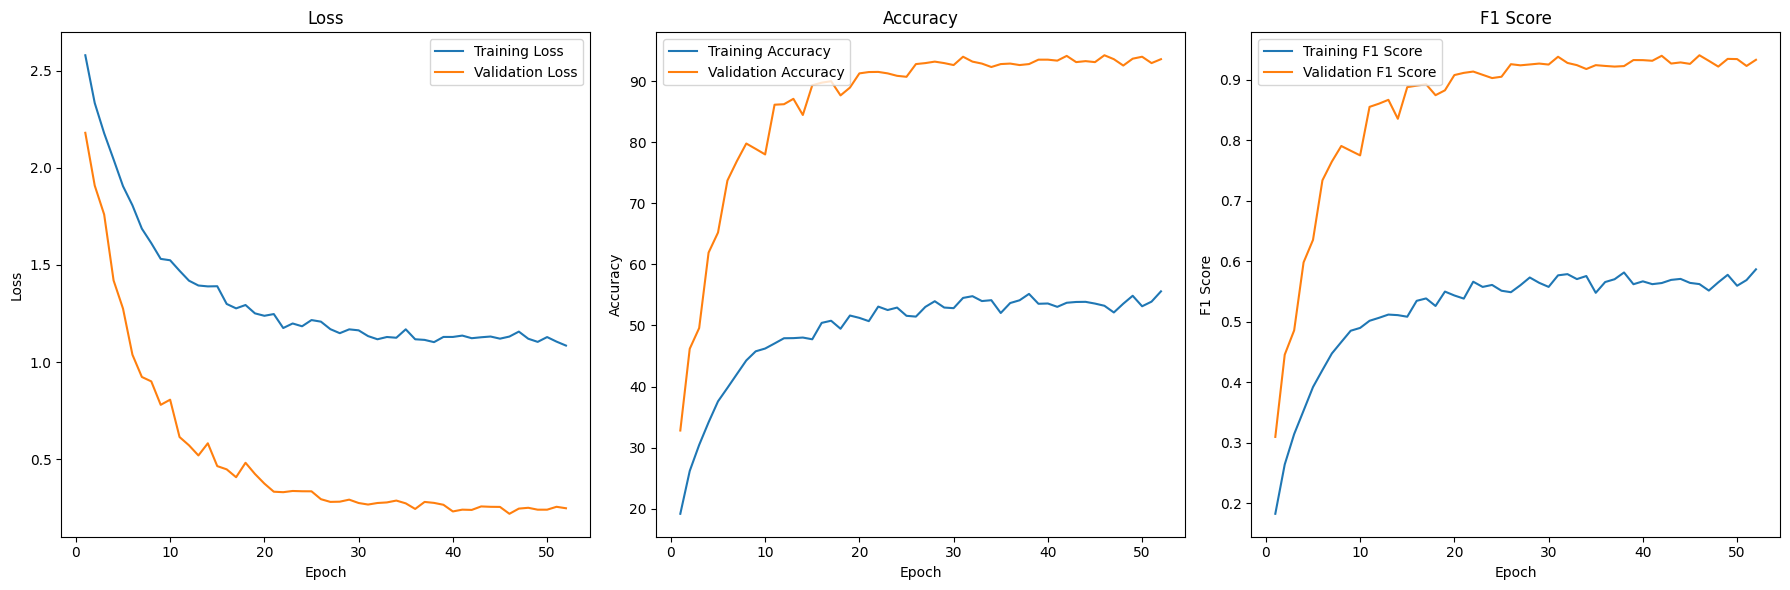

In [20]:
# Plotting the loss, accuracy, and F1 score
actual_epochs = len(train_loss)

epochs_range = range(1, actual_epochs + 1)

plt.figure(figsize=(18, 6))

# Plot training & validation loss values
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation F1 score values
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_f1_score, label='Training F1 Score')
plt.plot(epochs_range, val_f1_score, label='Validation F1 Score')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [21]:
# Define the test dataset class
class TestJutePestDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 1])
        image = Image.open(img_name).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image

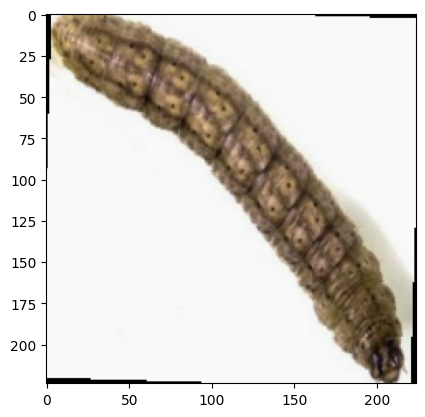

In [22]:
# Load and prepare test dataset
test_dir = '/kaggle/input/jutepest/test_images/'
test_csv = pd.read_csv('/kaggle/input/jutepest/test.csv')
test_dataset = TestJutePestDataset(test_csv, test_dir, transform)
plt.imshow(torch.permute(test_dataset[0], (1, 2, 0)))
plt.show()

In [23]:
# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
# Function for making predictions
def predict(model, test_loader):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for images in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
    
    return predictions


In [25]:
# Make predictions on test dataset
predictions = predict(model, test_loader)
predicted_labels = label_encoder.inverse_transform(predictions)

In [26]:
# Prepare submission file
test = pd.read_csv('/kaggle/input/jutepest/test.csv')
sub = pd.concat([test.id, pd.DataFrame(predicted_labels, columns=['class'])], axis=1)
sub.set_index('id', inplace=True)
sub.to_csv("submission_xception.csv")
sub

,class
id,
0,Cutworm
1,Jute Hairy
2,Black Hairy
3,Field Cricket
4,Black Hairy
...,...
1081,Termite
1082,Jute Hairy
1083,Jute Stem Girdler
